In [14]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [16]:
train_data = load_pickle_data("Train_features.pkl")
val_data = load_pickle_data("Val_features.pkl")
test_data = load_pickle_data("Test_features.pkl")

# Pre-processing

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def extract_features_labels(data):
    X_list = []
    
    for item in data:
        # STFT: Lấy mean, variance, max
        stft_mean = np.array(item['stft_mean'])
        stft_var = np.array(item['stft_var'])
        stft_max = np.array(item['stft_max'])

        mfcc_mean = np.array(item['mfcc'])
        mfcc_delta2_mean = np.array(item['mfcc_delta2'])

        feature_vector = np.concatenate([stft_mean, stft_var, stft_max, mfcc_mean, mfcc_delta2_mean])
        X_list.append(feature_vector)

    y = np.array([item['category'] for item in data])

    # Xác định số lượng feature
    num_stft = stft_mean.shape[0]
    num_mfcc = mfcc_mean.shape[0]

    feature_columns = (
        [f"stft_mean_{i}" for i in range(num_stft)] +
        [f"stft_var_{i}" for i in range(num_stft)] +
        [f"stft_max_{i}" for i in range(num_stft)] +
        [f"mfcc_mean_{i}" for i in range(num_mfcc)] +
        [f"mfcc_delta2_mean_{i}" for i in range(num_mfcc)]
    )

    return pd.DataFrame(X_list, columns=feature_columns), y

X_train, y_train = extract_features_labels(train_data)
X_val, y_val = extract_features_labels(val_data)
X_test, y_test = extract_features_labels(test_data)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("✅ Feature extraction and scaling completed!")


✅ Feature extraction and scaling completed!


In [18]:
print(f"Số cột của X_train: {X_train.shape[1]}")

Số cột của X_train: 891


In [19]:
# Kiểm tra ma trận tương quan
corr_train = X_train_scaled.corr()
corr_val = X_val_scaled.corr()
corr_test = X_test_scaled.corr()

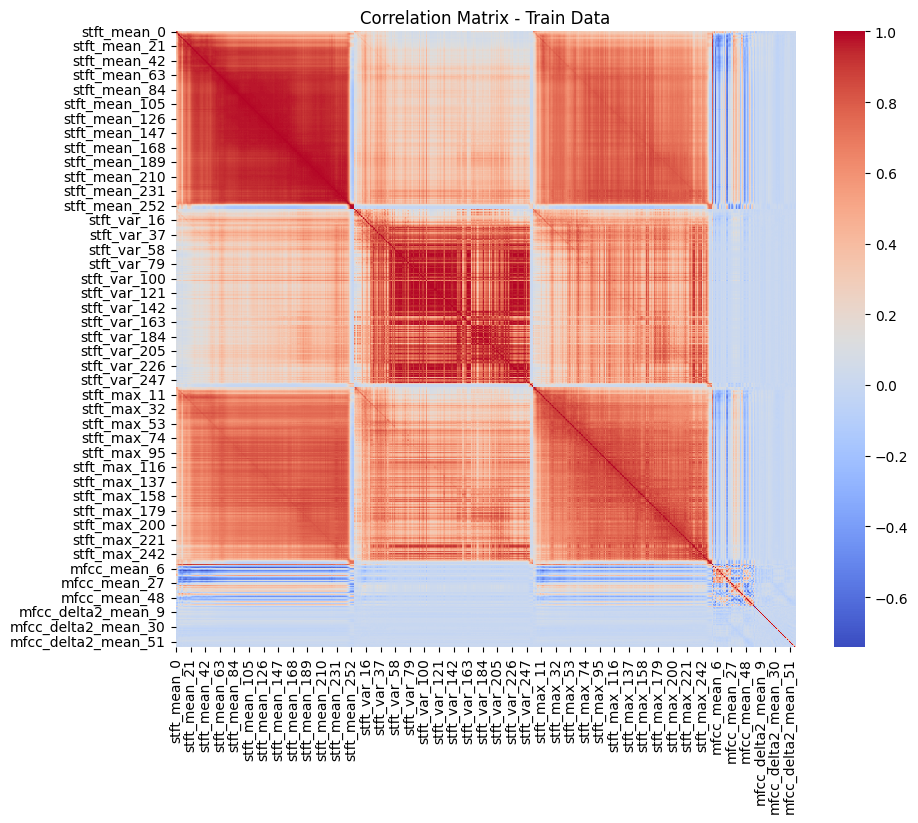

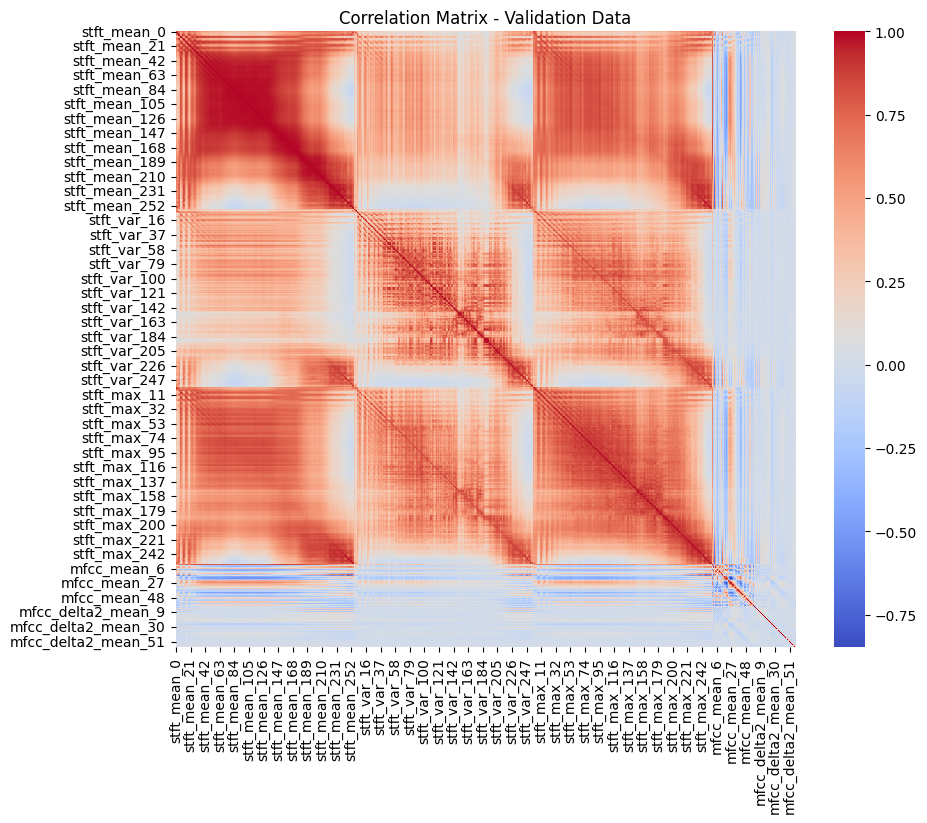

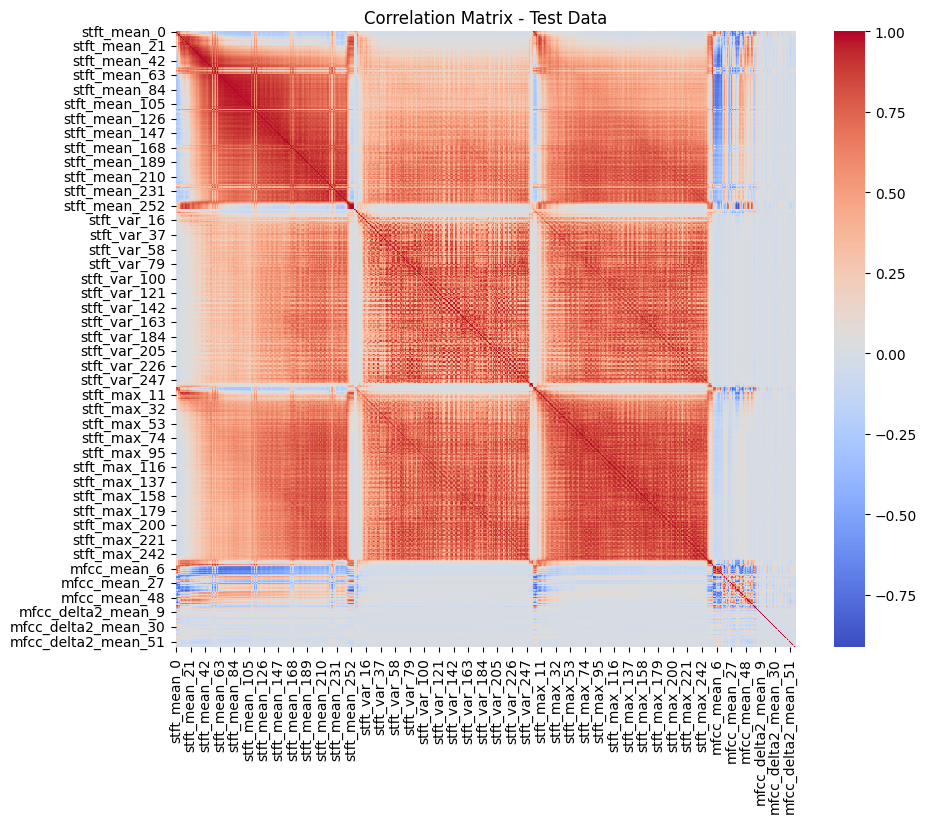

In [20]:
# Vẽ heatmap cho tập Train
plt.figure(figsize=(10, 8))
sns.heatmap(corr_train, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Train Data")
plt.show()

# Vẽ heatmap cho tập Validation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_val, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Validation Data")
plt.show()

# Vẽ heatmap cho tập Test
plt.figure(figsize=(10, 8))
sns.heatmap(corr_test, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Test Data")
plt.show()


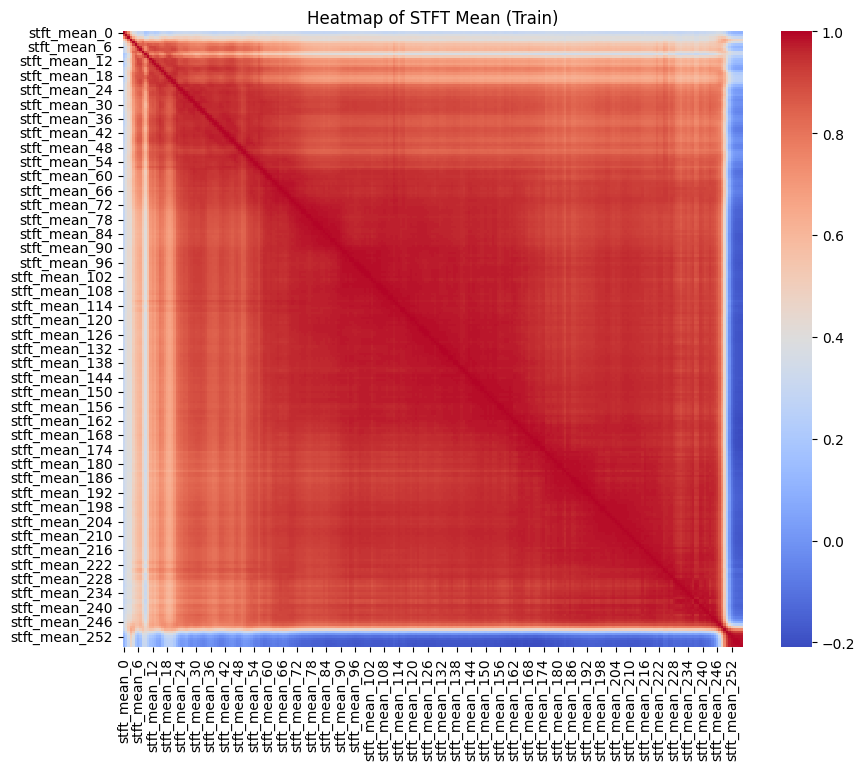

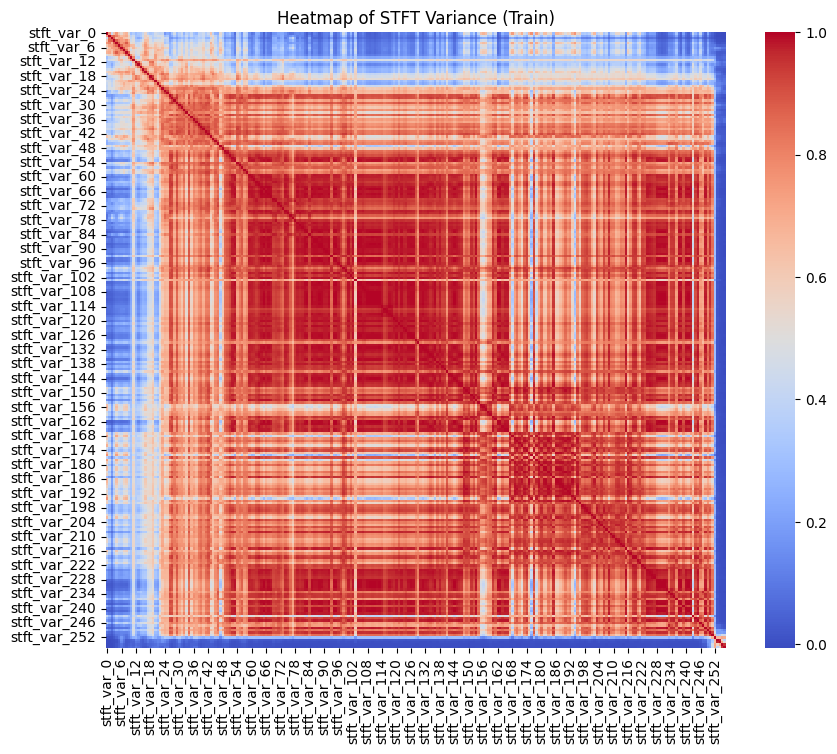

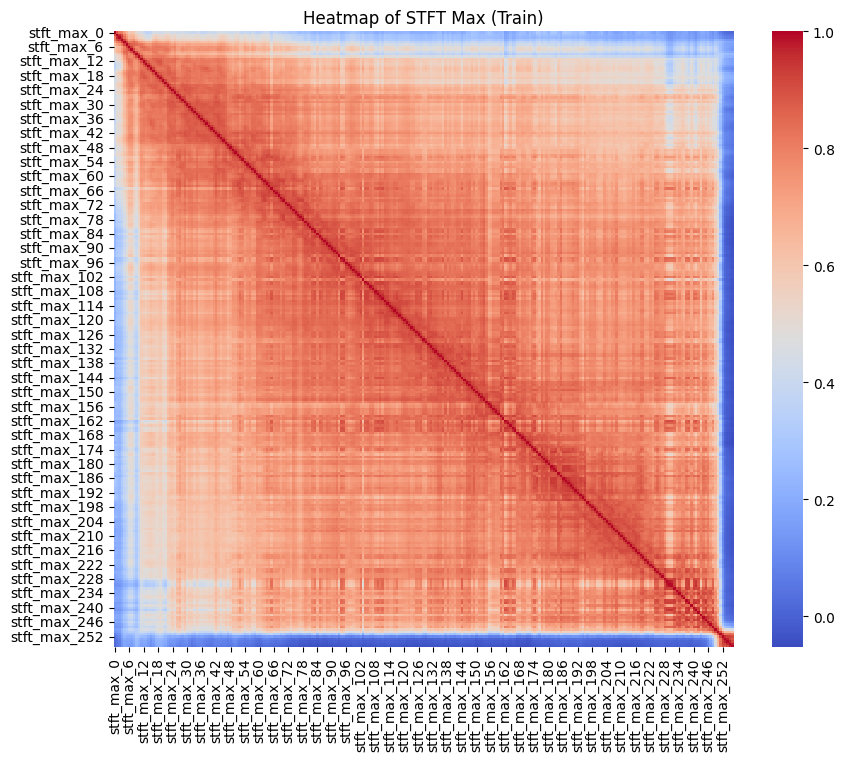

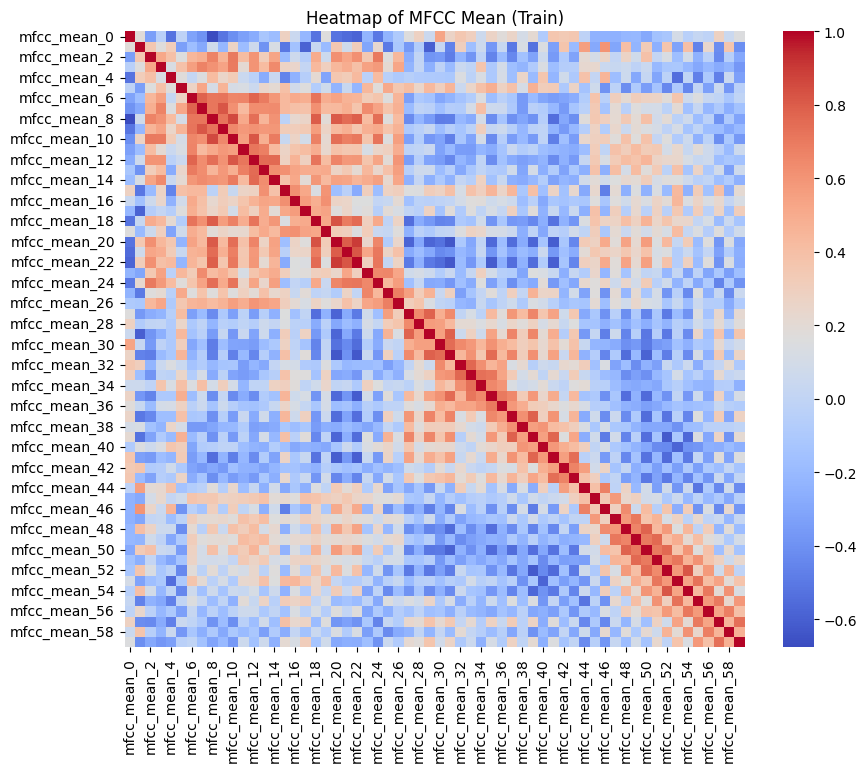

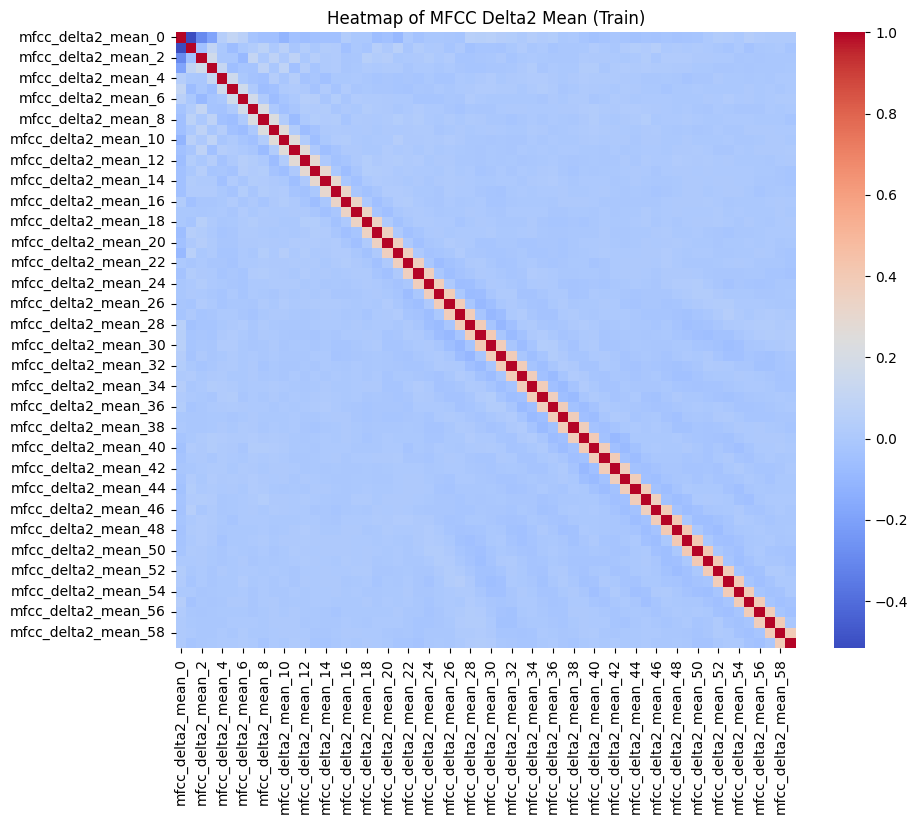

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Xác định chỉ số cột
stft_mean_end = 257
stft_var_end = stft_mean_end + 257
stft_max_end = stft_var_end + 257
mfcc_mean_end = stft_max_end + 60
mfcc_delta2_end = mfcc_mean_end + 60

feature_groups = {
    "STFT Mean": (0, stft_mean_end),
    "STFT Variance": (stft_mean_end, stft_var_end),
    "STFT Max": (stft_var_end, stft_max_end),
    "MFCC Mean": (stft_max_end, mfcc_mean_end),
    "MFCC Delta2 Mean": (mfcc_mean_end, mfcc_delta2_end),
}

# Vẽ heatmap cho từng nhóm
for feature_name, (start, end) in feature_groups.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_train_scaled.iloc[:, start:end].corr(), cmap='coolwarm', annot=False, fmt=".2f")
    plt.title(f"Heatmap of {feature_name} (Train)")
    plt.show()


                 Feature  Importance
779          mfcc_mean_8    0.033397
209        stft_mean_209    0.032052
229        stft_mean_229    0.026948
224        stft_mean_224    0.026751
793         mfcc_mean_22    0.023696
..                   ...         ...
267          stft_var_10    0.000000
554          stft_max_40    0.000000
551          stft_max_37    0.000000
549          stft_max_35    0.000000
890  mfcc_delta2_mean_59    0.000000

[891 rows x 2 columns]

Mean Importance: 0.001122
Max Importance: 0.033397
Median Importance: 0.000003


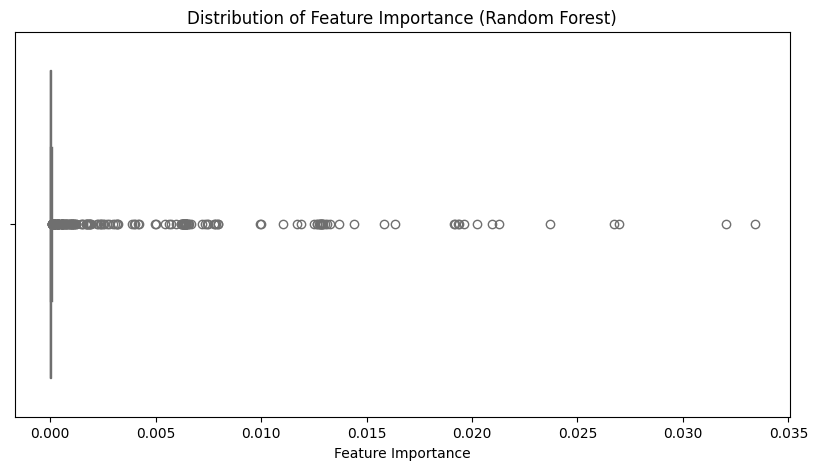

In [22]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Huấn luyện mô hình Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Lấy feature importance
feature_importances = rf.feature_importances_

# Chuyển thành DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

# In toàn bộ feature importance
print(feature_importance_df)

# Tính mean, max, median
importance_mean = feature_importance_df['Importance'].mean()
importance_max = feature_importance_df['Importance'].max()
importance_median = feature_importance_df['Importance'].median()

print(f"\nMean Importance: {importance_mean:.6f}")
print(f"Max Importance: {importance_max:.6f}")
print(f"Median Importance: {importance_median:.6f}")

# Vẽ Box Plot để xem phân bố
plt.figure(figsize=(10, 5))
sns.boxplot(x=feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Distribution of Feature Importance (Random Forest)")
plt.show()


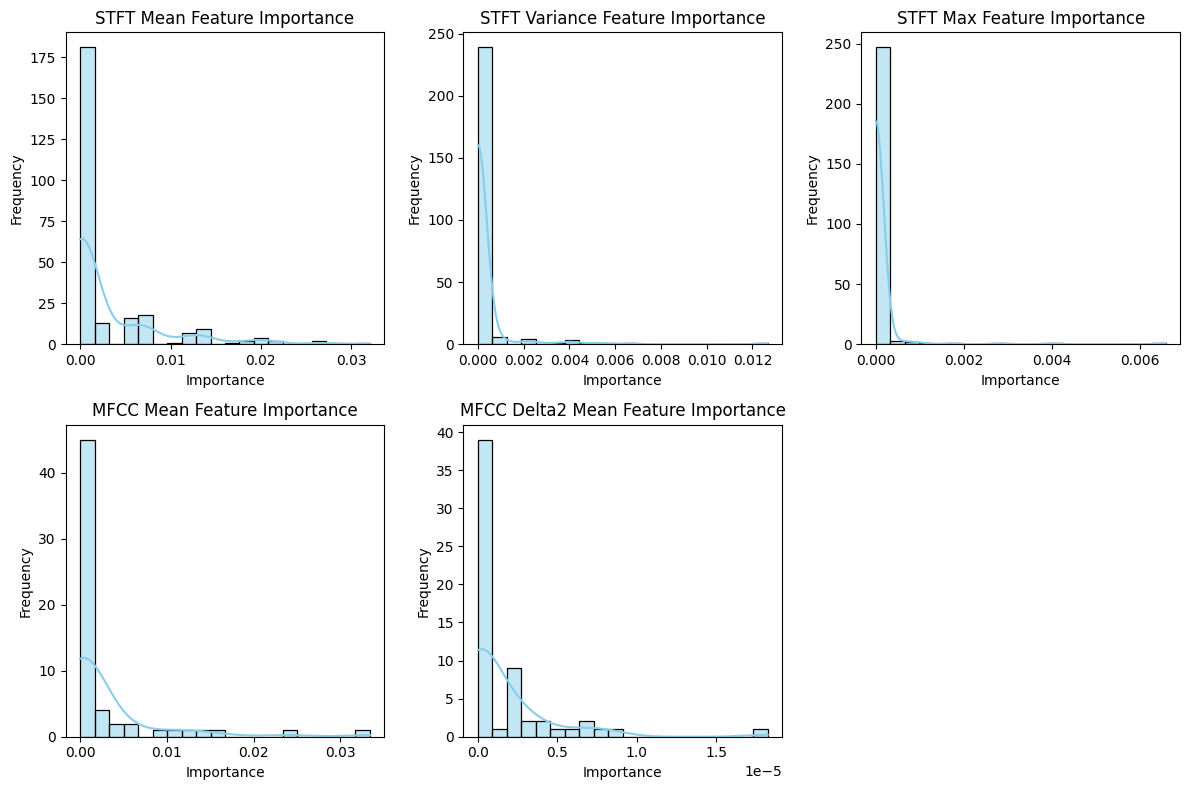

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo danh sách nhóm và từ khóa tương ứng
group_names = ["STFT Mean", "STFT Variance", "STFT Max", "MFCC Mean", "MFCC Delta2 Mean"]
group_filters = ["stft_mean", "stft_var", "stft_max", "mfcc_mean", "mfcc_delta2_mean"]

# Vẽ histogram cho từng nhóm
plt.figure(figsize=(12, 8))
for i, (group_name, filter_keyword) in enumerate(zip(group_names, group_filters), 1):
    group_df = feature_importance_df[feature_importance_df['Feature'].str.contains(filter_keyword, regex=False)]
    
    plt.subplot(2, 3, i)  # Chia thành 2 hàng, 3 cột
    sns.histplot(group_df['Importance'], bins=20, kde=True, color="skyblue")
    plt.title(f"{group_name} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [24]:
zero_importance_features = feature_importance_df[feature_importance_df["Importance"] == 0]
num_zero_importance = len(zero_importance_features)

print(f"Số lượng feature có Importance = 0: {num_zero_importance}")
print(zero_importance_features)


Số lượng feature có Importance = 0: 325
                 Feature  Importance
854  mfcc_delta2_mean_23         0.0
710         stft_max_196         0.0
860  mfcc_delta2_mean_29         0.0
698         stft_max_184         0.0
709         stft_max_195         0.0
..                   ...         ...
267          stft_var_10         0.0
554          stft_max_40         0.0
551          stft_max_37         0.0
549          stft_max_35         0.0
890  mfcc_delta2_mean_59         0.0

[325 rows x 2 columns]


In [25]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_scaled, y_train, discrete_features=False)

mi_df = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Mutual Information": mi_scores
}).sort_values(by="Mutual Information", ascending=False)

print(mi_df)


                 Feature  Mutual Information
772          mfcc_mean_1            0.658990
254        stft_mean_254            0.656610
255        stft_mean_255            0.655163
253        stft_mean_253            0.653513
256        stft_mean_256            0.646147
..                   ...                 ...
864  mfcc_delta2_mean_33            0.000000
862  mfcc_delta2_mean_31            0.000000
850  mfcc_delta2_mean_19            0.000000
855  mfcc_delta2_mean_24            0.000000
853  mfcc_delta2_mean_22            0.000000

[891 rows x 2 columns]


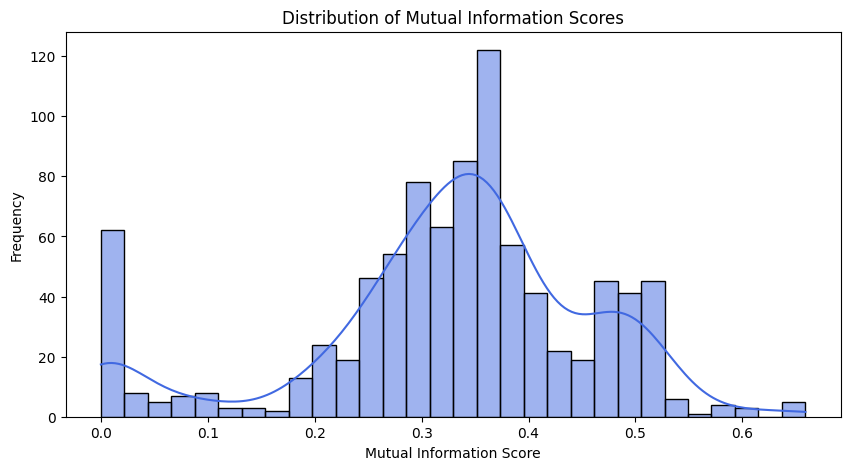

In [26]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

mi_scores = mutual_info_classif(X_train_scaled, y_train, discrete_features=False)

# Tạo DataFrame kết quả
mi_df = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Mutual Information": mi_scores
}).sort_values(by="Mutual Information", ascending=False)

# Vẽ biểu đồ histogram của MI scores
plt.figure(figsize=(10, 5))
sns.histplot(mi_df["Mutual Information"], bins=30, kde=True, color="royalblue")

# Thêm nhãn và tiêu đề
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.title("Distribution of Mutual Information Scores")

# Hiển thị biểu đồ
plt.show()



In [27]:
# Sắp xếp MI theo giá trị giảm dần
mi_df_sorted = mi_df.sort_values(by="Mutual Information", ascending=False)

# In danh sách feature theo thứ tự MI giảm dần
for feature, score in zip(mi_df_sorted["Feature"], mi_df_sorted["Mutual Information"]):
    print(f"{feature}: {score:.6f}")


mfcc_mean_1: 0.658990
stft_mean_254: 0.656610
stft_mean_255: 0.655163
stft_mean_253: 0.653513
stft_mean_256: 0.646147
stft_mean_244: 0.611637
stft_mean_252: 0.610410
mfcc_mean_20: 0.602042
stft_mean_243: 0.588352
stft_mean_245: 0.586828
mfcc_mean_22: 0.580603
mfcc_mean_8: 0.576970
stft_mean_242: 0.553148
stft_mean_250: 0.541973
stft_mean_241: 0.531880
mfcc_mean_10: 0.531032
stft_mean_226: 0.528117
stft_mean_234: 0.528071
stft_mean_232: 0.527277
stft_mean_230: 0.527166
stft_mean_218: 0.525551
stft_mean_229: 0.525252
stft_mean_236: 0.525133
stft_mean_233: 0.525057
stft_mean_231: 0.524762
stft_mean_235: 0.524373
stft_mean_219: 0.523998
stft_mean_246: 0.523824
stft_mean_237: 0.523171
stft_mean_239: 0.521508
stft_mean_217: 0.520854
stft_mean_132: 0.520712
stft_mean_238: 0.520377
stft_mean_133: 0.520164
stft_mean_216: 0.519763
stft_mean_240: 0.519154
stft_mean_215: 0.517979
stft_mean_212: 0.517203
stft_mean_134: 0.515155
stft_mean_222: 0.515081
stft_mean_135: 0.514456
stft_mean_211: 0.513633

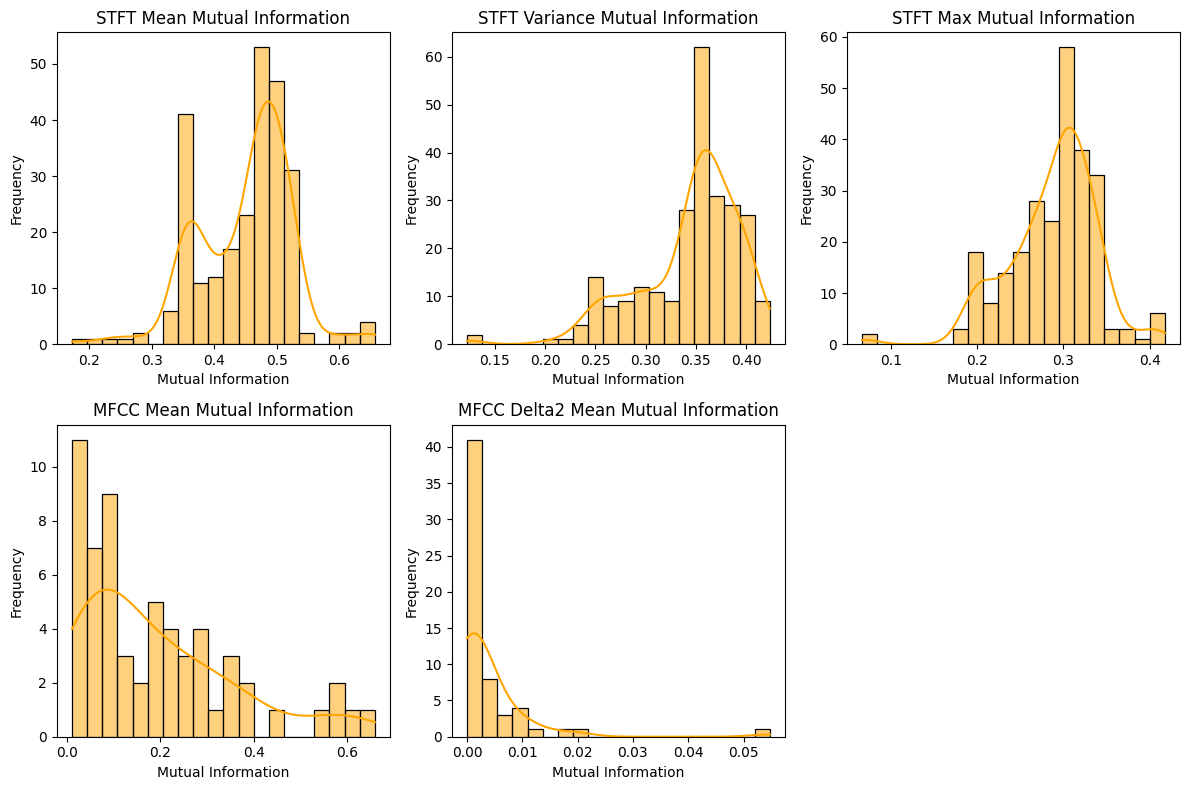

In [28]:
plt.figure(figsize=(12, 8))
for i, (group_name, filter_keyword) in enumerate(zip(group_names, group_filters), 1):
    group_df = mi_df[mi_df['Feature'].str.contains(filter_keyword, regex=False)]
    
    plt.subplot(2, 3, i)  # Chia thành 2 hàng, 3 cột
    sns.histplot(group_df['Mutual Information'], bins=20, kde=True, color="orange")
    plt.title(f"{group_name} Mutual Information")
    plt.xlabel("Mutual Information")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# MFCC (Processing)

In [29]:
selected_features = [col for col in X_train_scaled.columns if "mfcc_mean_" in col or "mfcc_delta2_mean_" in col]

X_train_selected = X_train_scaled[selected_features]
X_val_selected = X_val_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Số lượng feature sau khi chọn: {X_train_selected.shape[1]}")


Số lượng feature sau khi chọn: 120


In [30]:
from sklearn.ensemble import RandomForestClassifier  # hoặc RandomForestRegressor
import numpy as np
import pandas as pd

# Huấn luyện mô hình để lấy importance score
model = RandomForestClassifier(random_state=42)  # Chỉnh theo bài toán của bạn
model.fit(X_train_selected, y_train)

# Lưu importance score vào DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_train_selected.columns,
    "Importance": model.feature_importances_
})

# Tính giá trị trung bình của importance
mean_importance = feature_importance_df["Importance"].mean()

# Lọc các cột có importance < mean
low_importance_features = feature_importance_df[feature_importance_df["Importance"] < mean_importance]["Feature"].values

# Các cột còn lại giữ nguyên
high_importance_features = feature_importance_df[feature_importance_df["Importance"] >= mean_importance]["Feature"].values

X_train_high = X_train_selected[high_importance_features]
X_val_high = X_val_selected[high_importance_features]
X_test_high = X_test_selected[high_importance_features]


In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi PCA
scaler = StandardScaler()
X_train_low_scaled = scaler.fit_transform(X_train_selected[low_importance_features])
X_val_low_scaled = scaler.transform(X_val_selected[low_importance_features])
X_test_low_scaled = scaler.transform(X_test_selected[low_importance_features])

# Áp dụng PCA với 5 thành phần
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_low_scaled)
X_val_pca = pca.transform(X_val_low_scaled)
X_test_pca = pca.transform(X_test_low_scaled)

# Chuyển thành DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(5)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)


In [32]:
num_zero_importance = (feature_importance_df["Importance"] == 0).sum()
print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature có importance >= mean: {len(high_importance_features)}")
print(f"Số lượng feature có importance = 0: {num_zero_importance}")


Số lượng feature ban đầu: 120
Số lượng feature có importance >= mean: 25
Số lượng feature có importance = 0: 0


In [33]:
X_train_final = pd.concat([X_train_high.reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val_high.reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test_high.reset_index(drop=True), X_test_pca_df], axis=1)

print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_train_final.shape[1]}")


Số lượng feature ban đầu: 120
Số lượng feature sau khi PCA: 30


In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi PCA
scaler = StandardScaler()
X_train_low_scaled = scaler.fit_transform(X_train_selected[low_importance_features])
X_val_low_scaled = scaler.transform(X_val_selected[low_importance_features])
X_test_low_scaled = scaler.transform(X_test_selected[low_importance_features])

# Áp dụng PCA với 5 thành phần
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_low_scaled)
X_val_pca = pca.transform(X_val_low_scaled)
X_test_pca = pca.transform(X_test_low_scaled)

# Chuyển thành DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(5)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

num_zero_importance = (feature_importance_df["Importance"] == 0).sum()
print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature có importance >= mean: {len(high_importance_features)}")
print(f"Số lượng feature có importance = 0: {num_zero_importance}")

X_train_final = pd.concat([X_train_high.reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val_high.reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test_high.reset_index(drop=True), X_test_pca_df], axis=1)

print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_train_final.shape[1]}")

Số lượng feature ban đầu: 120
Số lượng feature có importance >= mean: 25
Số lượng feature có importance = 0: 0
Số lượng feature ban đầu: 120
Số lượng feature sau khi PCA: 30


In [35]:
print(f"Số lượng feature sau khi PCA: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_test_final.shape[1]}")

Số lượng feature sau khi PCA: 30
Số lượng feature sau khi PCA: 30


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Kiểm tra số lượng feature
print(f"Số lượng feature ban đầu: {X_train_high.shape[1]}")
print(f"Số lượng feature sau PCA: {X_train_final.shape[1]}")

# Định nghĩa tham số GridSearch
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Chạy GridSearch trên tập validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val_final, y_val)

best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Huấn luyện mô hình với tham số tối ưu
rf_final = RandomForestClassifier(**best_params, random_state=42)
rf_final.fit(X_train_final, y_train)

# Dự đoán trên tập validation & test
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Đánh giá mô hình
def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

evaluate_model(y_val, y_val_pred, "RF Hybrid (Validation)")
evaluate_model(y_test, y_test_pred, "RF Hybrid (Test)")


Số lượng feature ban đầu: 25
Số lượng feature sau PCA: 30

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RF Hybrid (Validation) - Accuracy: 0.9962, F1-score: 0.9962
RF Hybrid (Test) - Accuracy: 0.9468, F1-score: 0.9466


# PCA STFT

In [37]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Chọn các cột 'stft_*' từ X_train_scaled
stft_columns = [col for col in X_train_scaled.columns if col.startswith("stft_")]

# Lấy dữ liệu STFT từ X_train_scaled
X_stft = X_train_scaled[stft_columns]

# 1️⃣ Tính ma trận tương quan
correlation_matrix = X_stft.corr().abs()

# 2️⃣ Tìm các cặp có tương quan cao (> 0.99)
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.99:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.add((col1, col2))

# 3️⃣ Dùng RandomForest để tìm feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_stft, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_stft.columns)

# 4️⃣ Xóa cột có feature importance cao hơn trong mỗi cặp
columns_to_drop = set()
for col1, col2 in high_corr_pairs:
    if feature_importances[col1] > feature_importances[col2]:
        columns_to_drop.add(col1)
    else:
        columns_to_drop.add(col2)

# 5️⃣ Xóa các cột đã chọn
X_stft_filtered = X_stft.drop(columns=columns_to_drop)
print(f"Đã loại bỏ {len(columns_to_drop)} cột có tương quan cao.")

# 6️⃣ Chuẩn hóa dữ liệu sau khi lọc
scaler = StandardScaler()
X_stft_scaled = scaler.fit_transform(X_stft_filtered)

print(f"Số thành phần PCA tối ưu: 4")

pca = PCA(n_components=4, random_state=42)
X_stft_pca = pca.fit_transform(X_stft_scaled)

stft_pca_columns = [f"stft_PCA_{i+1}" for i in range(4)]
X_stft_pca_df = pd.DataFrame(X_stft_pca, columns=stft_pca_columns)
print(f"Số lượng feature STFT PCA: {X_stft_pca_df.shape[1]}")
X_train_final = pd.concat([X_train_final.reset_index(drop=True), X_stft_pca_df], axis=1)

X_val_stft = X_val_scaled[stft_columns]
X_test_stft = X_test_scaled[stft_columns]
print(f"Số lượng feature sau khi thêm STFT PCA: {X_train_final.shape[1]}")
# Lọc lại columns_to_drop cho X_val_stft và X_test_stft
columns_to_drop_val = [col for col in columns_to_drop if col in X_val_stft.columns]
columns_to_drop_test = [col for col in columns_to_drop if col in X_test_stft.columns]

# Áp dụng PCA cho X_val và X_test
X_val_stft_filtered = X_val_stft.drop(columns=columns_to_drop_val)
X_test_stft_filtered = X_test_stft.drop(columns=columns_to_drop_test)

X_val_stft_scaled = scaler.transform(X_val_stft_filtered)
X_test_stft_scaled = scaler.transform(X_test_stft_filtered)

X_val_stft_pca = pca.transform(X_val_stft_scaled)
X_test_stft_pca = pca.transform(X_test_stft_scaled)

X_val_stft_pca_df = pd.DataFrame(X_val_stft_pca, columns=stft_pca_columns)
X_test_stft_pca_df = pd.DataFrame(X_test_stft_pca, columns=stft_pca_columns)

X_val_final = pd.concat([X_val_final.reset_index(drop=True), X_val_stft_pca_df], axis=1)
X_test_final = pd.concat([X_test_final.reset_index(drop=True), X_test_stft_pca_df], axis=1)

# Kiểm tra số lượng cột sau khi thêm PCA
print(f"Số lượng feature sau khi thêm STFT PCA vào X_val_final: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi thêm STFT PCA vào X_test_final: {X_test_final.shape[1]}")

Đã loại bỏ 246 cột có tương quan cao.
Số thành phần PCA tối ưu: 4
Số lượng feature STFT PCA: 4
Số lượng feature sau khi thêm STFT PCA: 34
Số lượng feature sau khi thêm STFT PCA vào X_val_final: 34
Số lượng feature sau khi thêm STFT PCA vào X_test_final: 34


In [38]:
print(f"Số lượng feature sau khi PCA: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_test_final.shape[1]}")

Số lượng feature sau khi PCA: 34
Số lượng feature sau khi PCA: 34


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

best_val_accuracy = 0
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_final, y_train)

    y_val_pred = model.predict(X_val_final)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_model = model

print(f"🔍 Best parameters (based on validation): {best_params}")

y_val_pred = best_model.predict(X_val_final)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_accuracy:.4f}")

y_test_pred = best_model.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")


🔍 Best parameters (based on validation): {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

📊 Đánh giá trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      2200
     Swarming       0.99      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449

✅ Accuracy trên tập validation: 0.9973

📊 Đánh giá trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      0.99      5600
     Swarming       0.99      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

✅ Accuracy trên tập test: 0.9939


In [40]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from itertools import product

# Danh sách các mô hình và tham số cần tìm kiếm
models_params = {
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [10, 20, 30, 40, 50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {} 
    }
}

# Lưu kết quả
results = []

for model_name, model_info in models_params.items():
    print(f"\n🔍 Đang tìm tham số tốt nhất cho {model_name}...")

    best_model = None
    best_val_acc = 0
    best_params = "Default"

    # Tìm kiếm tham số tốt nhất
    param_grid = model_info["params"]
    if param_grid:
        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    else:
        param_combinations = [{}]

    for params in param_combinations:
        model = model_info["model"].set_params(**params)
        model.fit(X_train_final, y_train)
        y_val_pred = model.predict(X_val_final)
        val_acc = accuracy_score(y_val, y_val_pred)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_params = params

    print(f"✅ {model_name} - Best Params: {best_params}")

    # Đánh giá trên validation và test
    y_val_pred = best_model.predict(X_val_final)
    y_test_pred = best_model.predict(X_test_final)

    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"\n📊 Đánh giá {model_name} trên tập validation:")
    print(classification_report(y_val, y_val_pred))

    print(f"\n📊 Đánh giá {model_name} trên tập test:")
    print(classification_report(y_test, y_test_pred))

    print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
    print(f"✅ Accuracy trên tập test: {test_acc:.4f}")

    results.append([model_name, best_params, val_acc, test_acc])

results_df = pd.DataFrame(results, columns=["Model", "Best Params", "Validation Accuracy", "Test Accuracy"])
print("\n📌 Tổng hợp kết quả:")
print(results_df)


🔍 Đang tìm tham số tốt nhất cho SVM...
✅ SVM - Best Params: {'C': 0.01, 'kernel': 'linear', 'gamma': 'scale'}

📊 Đánh giá SVM trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.80      0.89      2200
     Swarming       0.83      1.00      0.91      2249

     accuracy                           0.90      4449
    macro avg       0.92      0.90      0.90      4449
 weighted avg       0.92      0.90      0.90      4449


📊 Đánh giá SVM trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.47      0.64      5600
     Swarming       0.65      1.00      0.79      5600

     accuracy                           0.73     11200
    macro avg       0.83      0.73      0.71     11200
 weighted avg       0.83      0.73      0.71     11200

✅ Accuracy trên tập validation: 0.8993
✅ Accuracy trên tập test: 0.7350

🔍 Đang tìm tham số tốt nhất cho KNN...
✅ KNN - Best Params: {'n_neighbors': 3, 'we

In [41]:
print(results_df[results_df["Model"] == "KNN"]["Best Params"].values[0])


{'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}


# Soft Voting

In [42]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\n📊 Đánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Soft Voting trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.92      0.96      2200
     Swarming       0.92      1.00      0.96      2249

     accuracy                           0.96      4449
    macro avg       0.96      0.96      0.96      4449
 weighted avg       0.96      0.96      0.96      4449


📊 Đánh giá Soft Voting trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.90      0.95      5600
     Swarming       0.91      1.00      0.95      5600

     accuracy                           0.95     11200
    macro avg       0.96      0.95      0.95     11200
 weighted avg       0.96      0.95      0.95     11200

✅ Accuracy trên tập validation: 0.9589
✅ Accuracy trên tập test: 0.9519


# Hard Voting

In [43]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='hard', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

# Đánh giá
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\n📊 Đánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Soft Voting trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      2200
     Swarming       0.99      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449


📊 Đánh giá Soft Voting trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.96      0.98      5600
     Swarming       0.96      1.00      0.98      5600

     accuracy                           0.98     11200
    macro avg       0.98      0.98      0.98     11200
 weighted avg       0.98      0.98      0.98     11200

✅ Accuracy trên tập validation: 0.9953
✅ Accuracy trên tập test: 0.9796


# Weighted voting

In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

weights = []
for name, model in best_models:
    model.fit(X_train_final, y_train)
    y_val_pred = model.predict(X_val_final)
    acc = accuracy_score(y_val, y_val_pred)
    weights.append(acc)
    
print("Weights theo accuracy trên validation:", weights)

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', weights=weights, n_jobs=-1)

soft_voting_clf.fit(X_train_final, y_train)

y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")


Weights theo accuracy trên validation: [0.9291975724881996, 0.9186334007642166, 0.9901101371094628, 0.99685322544392, 0.9941559901101371]
✅ Accuracy trên tập validation: 0.9658
✅ Accuracy trên tập test: 0.9527


# Stacking

In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - dùng Logistic Regression (thay vì Linear Regression vì bài toán phân loại)
meta_model = LogisticRegression(random_state=42)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      2200
     Swarming       0.99      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449

✅ Accuracy trên tập validation: 0.9971

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.96      0.98      5600
     Swarming       0.96      1.00      0.98      5600

     accuracy                           0.98     11200
    macro avg       0.98      0.98      0.98     11200
 weighted avg       0.98      0.98      0.98     11200

✅ Accuracy trên tập test: 0.9806


In [46]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - Random Forest
meta_model = RandomForestClassifier(
    n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      1.00      1.00      2200
     Swarming       1.00      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449

✅ Accuracy trên tập validation: 0.9978

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      5600
     Swarming       0.98      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

✅ Accuracy trên tập test: 0.9912


In [47]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - Extra Trees
meta_model = ExtraTreesClassifier(
    n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      2200
     Swarming       0.99      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449

✅ Accuracy trên tập validation: 0.9964

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      5600
     Swarming       0.98      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

✅ Accuracy trên tập test: 0.9886


# Extra tree

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [30, 40, 50, 60, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Khởi tạo mô hình Random Forest
rf_model = ExtraTreesClassifier(random_state=42)

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

# Chạy Grid Search trên tập huấn luyện
grid_search.fit(X_train_final, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print(f"🔍 Best parameters: {best_params}")

# Huấn luyện mô hình với tham số tối ưu
best_model = ExtraTreesClassifier(**best_params, random_state=42)
best_model.fit(X_train_final, y_train)

# Dự đoán trên tập validation và test
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

# Đánh giá mô hình trên tập validation
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))

# Đánh giá mô hình trên tập test
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))

# In accuracy trên validation và test
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n✅ Accuracy trên tập validation: {val_accuracy:.4f}")
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")


Fitting 5 folds for each of 756 candidates, totalling 3780 fits
🔍 Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

📊 Đánh giá trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      2200
     Swarming       0.99      1.00      1.00      2249

     accuracy                           1.00      4449
    macro avg       1.00      1.00      1.00      4449
 weighted avg       1.00      1.00      1.00      4449


📊 Đánh giá trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      5600
     Swarming       0.99      1.00      1.00      5600

     accuracy                           1.00     11200
    macro avg       1.00      1.00      1.00     11200
 weighted avg       1.00      1.00      1.00     11200


✅ Accuracy trên tập validation: 0.9964
✅ Accuracy trên tập test: 0.9973
